In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
X = np.linspace(-10, 10, 500)
X = X[:, np.newaxis]
y = np.array([3 * np.sin(x) + np.random.random() * 5 + i / 50 for i, x in enumerate(X)]).flatten()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [3]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf_node(self):
        return self.value is not None

In [4]:
class DecisionTree:
    def __init__(self, min_samples=2, max_depth=10):
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.tree = []
    
    def fit(self, X, y):
        self.tree = self.grow_tree(X, y)
    
    def predict(self, X):
        return np.array([self.travers_tree(x, self.tree) for x in X])
    
    def most_common(self, y): 
        return y.mean()
    
    def entropy(self, y):
        mse = np.sum((y.mean() - y)**2) / len(y)
        mae = np.sum(np.abs(y.mean() - y)) / len(y)
        return mse
    
    def best_split(self, X, y):
        best_feature, best_threshold = None, None
        best_gain = -1
        
        for i in range(X.shape[1]):
            thresholds = np.unique(X[:, i])
            for threshold in thresholds:
                gain = self.information_gain(X[:, i], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = i
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def information_gain(self, X_column, y, threshold):        
        if len(np.unique(y)) == 1: 
            return -1
        
        n = len(y)
        parent = self.entropy(y)
        
        left_indexes = np.argwhere(X_column <= threshold).flatten()
        right_indexes = np.argwhere(X_column > threshold).flatten()
        
        if len(left_indexes) == 0 or len(right_indexes) == 0:
            return 0
    
        e_l, n_l = self.entropy(y[left_indexes]), len(left_indexes)
        e_r, n_r = self.entropy(y[right_indexes]), len(right_indexes)
        
        child = (n_l / n) * e_l + (n_r / n) * e_r
        return parent - child
    
    def grow_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        n_labels = len(np.unique(y))

        if n_samples < self.min_samples or n_labels == 1 or depth >= self.max_depth:
            return Node(value=self.most_common(y))
        
        best_feature, best_threshold = self.best_split(X, y)
        
        left_indexes = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        right_indexes = np.argwhere(X[:, best_feature] > best_threshold).flatten()
        
        left = self.grow_tree(X[left_indexes, :], y[left_indexes], depth+1)
        right = self.grow_tree(X[right_indexes, :], y[right_indexes], depth+1)
        
        return Node(best_feature, best_threshold, left, right)
    
    def travers_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.value
        
        if x[tree.feature] <= tree.threshold:
            return self.travers_tree(x, tree.left)

        return self.travers_tree(x, tree.right)

In [5]:
def score(predicted, y):
    return 1 - np.sum((predicted - y)**2) / np.sum((y.mean() - y)**2)

dt_reg = DecisionTree(max_depth=5)
dt_reg.fit(X_train, y_train)

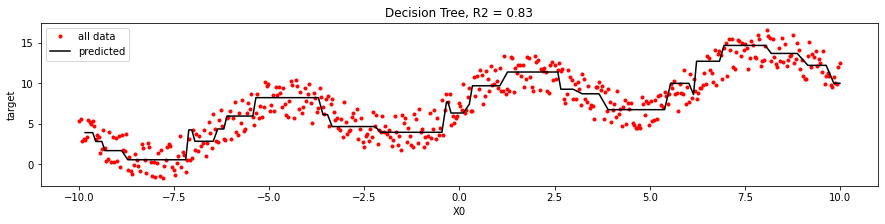

In [6]:
plt.subplots(figsize=(15, 3))

predicted = dt_reg.predict(X_test)
indexes = np.argsort(X_test[:, 0])

plt.plot(X, y, ".r", label="all data")
plt.plot(np.sort(X_test[:, 0]), predicted[indexes], "-k", label="predicted")

plt.ylabel("target")
plt.xlabel("X0")
plt.title("Decision Tree, R2 = " + str(round(score(predicted, y_test), 2)))
plt.legend()

plt.show()

In [98]:
class AdaBoost:
    def __init__(self, n_estimators=20, method="RT"):
        self.n_estimators = n_estimators
        self.stumps = []
        self.X = []
        self.y = []
        self.weights = []
        self.asay = []
        self.method = method
        
    def fit(self, X, y):
        n = len(y)
        w = np.ones(n) / n
        phi = 0.1
        
        for i in range(self.n_estimators):
            stump = DecisionTree(max_depth=1)
            stump.fit(X, y)
            predictions = stump.predict(X)
            
            self.stumps.append(stump)
            self.X.append(X)
            self.y.append(y)
            
            if self.method == "RT":
                error = np.abs((predictions - y) / y)
                et = np.sum(np.where(error > phi, w, 0))
                bt = et**2
                w *= np.where(error < phi, bt, 1)
            if self.method == "R2":
                lt = np.abs(predictions - y)
                Lt = lt / max(lt)
                Lt *= Lt
                Lt = 1 - np.exp((-1) * lt / max(lt))
                Lt_avr = np.sum(Lt * w)
                bt = Lt_avr / (1 - Lt_avr)
                w *= bt**(1 - Lt)
            
            w /= np.sum(w)
            amount_of_say = np.log(1 / bt)
            self.asay.append(amount_of_say)
            self.weights.append(w.copy())
            
            for j in range(1, n):
                w[j] = w[j] + w[j - 1]
                
            indexes = [np.where(w > np.random.random())[0][0] for _ in range(n)]
            
            X = X[indexes].copy()
            y = y[indexes].copy()
            w = np.ones(n) / n
            
    def predict(self, X, n):
        predict = np.zeros(X.shape[0])
        
        for i in range(n):
            predict += self.stumps[i].predict(X) * self.asay[i]
            
        return predict / np.sum(self.asay)
    
    def weak_predict(self, X, n):
        return self.stumps[n].predict(X)
    
    def score(self, predicted, y):
        return 1 - np.sum((predicted - y)**2) / np.sum((y.mean() - y)**2)            

In [100]:
ab_reg = AdaBoost(n_estimators=20, method="R2")
ab_reg.fit(X_train, y_train)

predict = ab_reg.predict(X_test, ab_reg.n_estimators)
print(ab_reg.score(predict, y_test))

0.6752732118656126


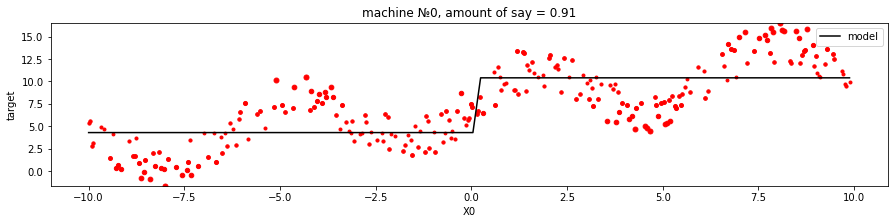

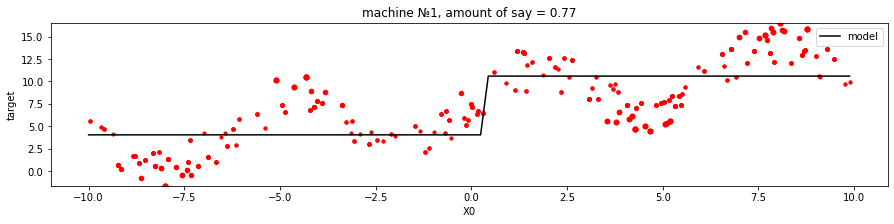

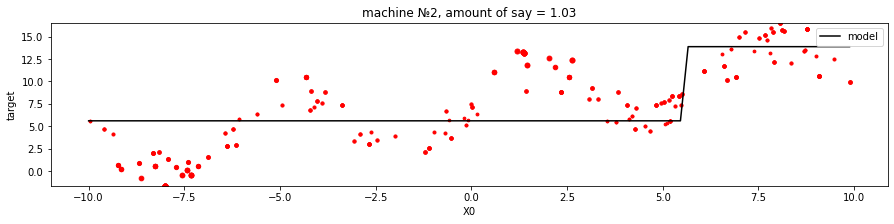

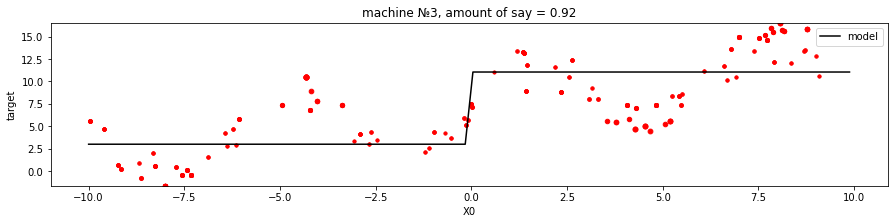

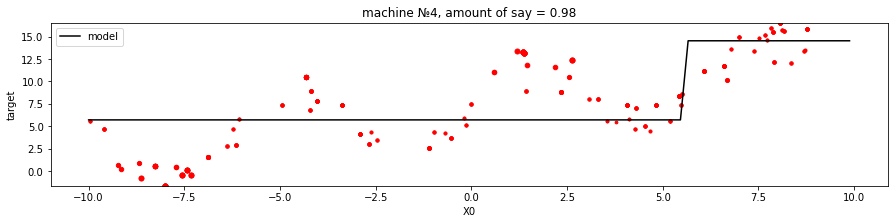

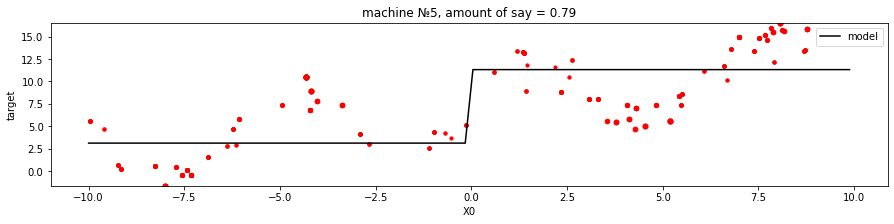

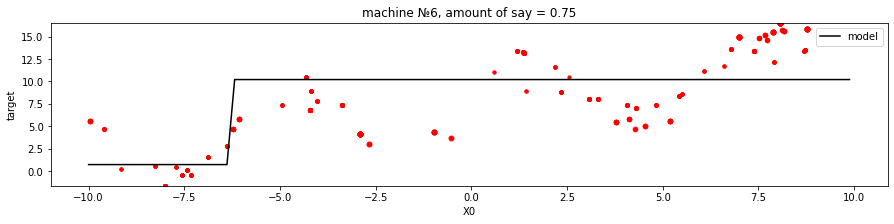

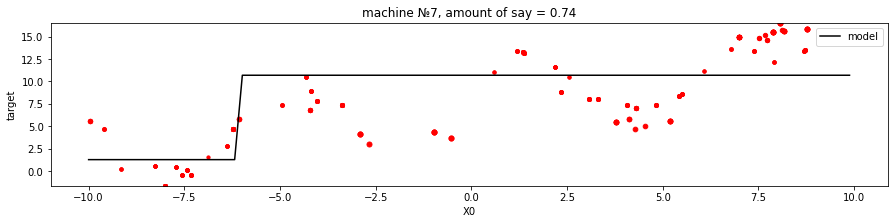

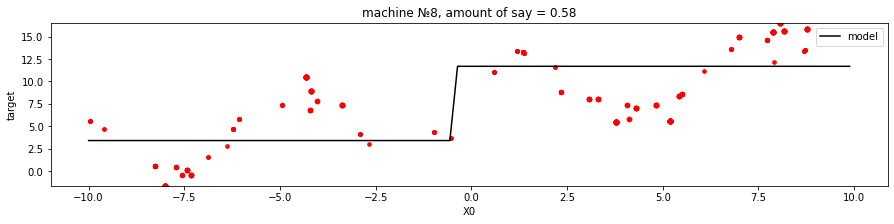

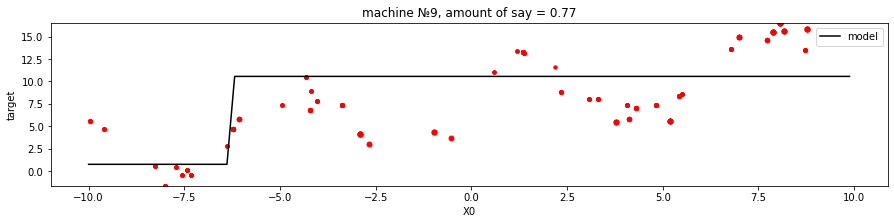

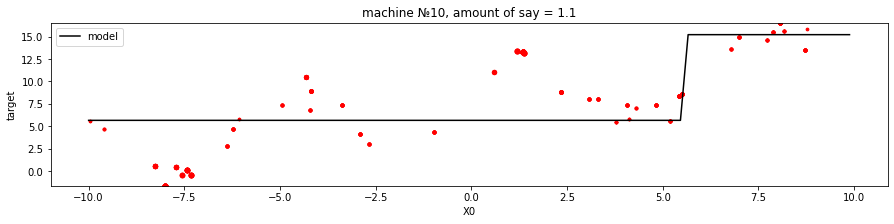

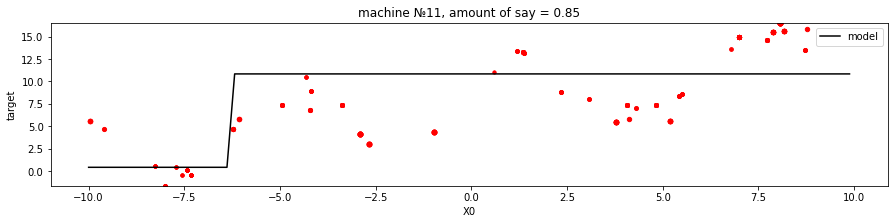

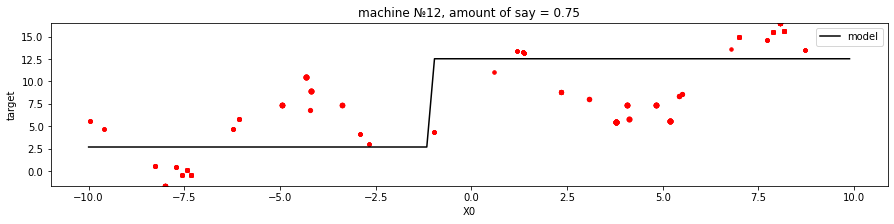

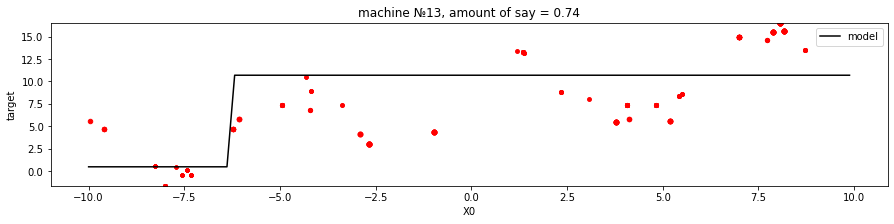

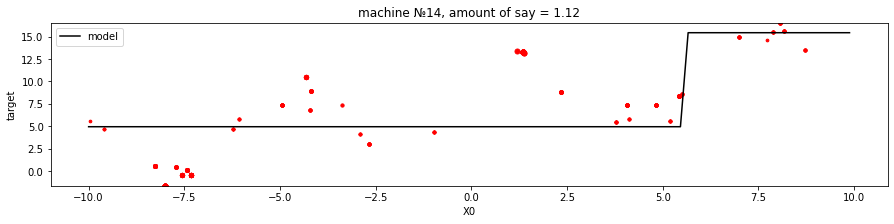

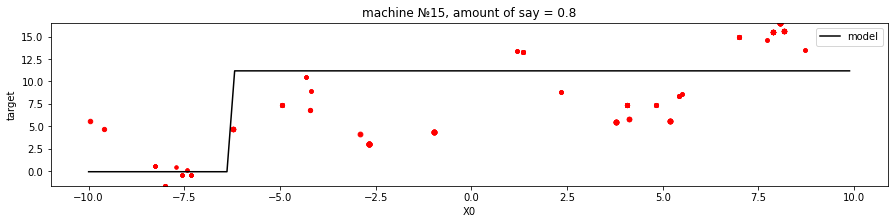

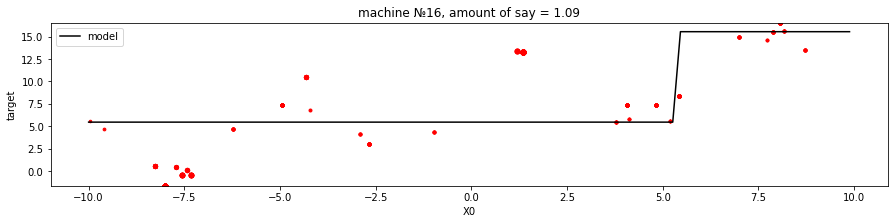

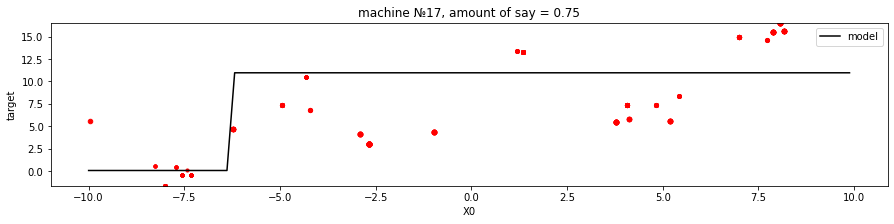

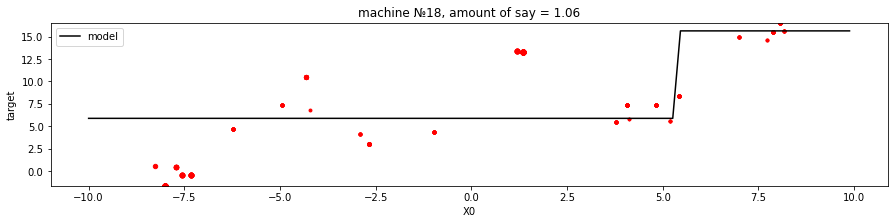

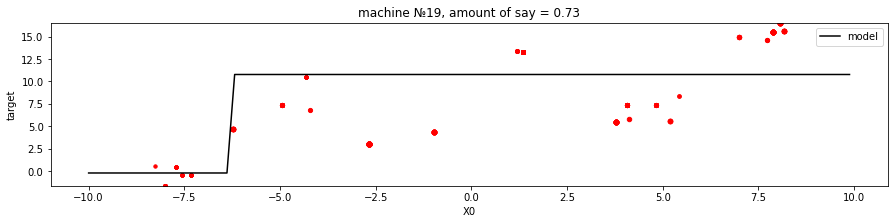

In [101]:
machines = []

X_min, X_max = min(ab_reg.X[0]), max(ab_reg.X[0])
y_min, y_max = min(ab_reg.y[0]), max(ab_reg.y[0])

X_weak_test = np.linspace(X_min, X_max, 100)

for i in range(ab_reg.n_estimators):
    X_ = ab_reg.X[i]
    y_ = ab_reg.y[i]
    w_ = ab_reg.weights[i]
    
    predicted = ab_reg.weak_predict(X_weak_test, i)    
    machines.append(i)
    
    wmax = max(w_)
    
    plt.subplots(figsize=(15, 3))
    
    for j in range(len(y_)):
        plt.plot(X_[j], y_[j], ".r", markersize=10 * w_[j] / wmax)
    
    plt.plot(X_weak_test, predicted, "-k", label="model")

    plt.ylabel("target")
    plt.xlabel("X0")
    plt.ylim(y_min, y_max)
    plt.title("machine №" + str(i) + ", amount of say = " + str(round(ab_reg.asay[i], 2)))
    plt.legend()
    plt.show()

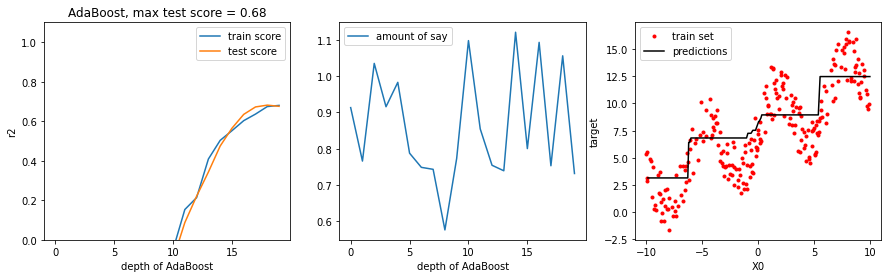

In [102]:
def plot_three_some():
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    axes[0].plot(machines, train_score, label="train score")
    axes[0].plot(machines, test_score, label="test score")

    axes[0].set_ylabel("r2")
    axes[0].set_xlabel("depth of AdaBoost")
    axes[0].set_title("AdaBoost, max test score = " + str(round(test_score[-1], 2)))
    axes[0].set_ylim(0, 1.1)
    axes[0].legend()

    axes[1].plot(machines, ab_reg.asay, label="amount of say")
    axes[1].set_xlabel("depth of AdaBoost")
    axes[1].legend()

    predicted = ab_reg.predict(X_test, ab_reg.n_estimators)
    indexes = np.argsort(X_test[:, 0])

    axes[2].plot(X_train, y_train, ".r", label="train set")
    axes[2].plot(np.sort(X_test[:, 0]), predicted[indexes], "-k", label="predictions")

    axes[2].set_ylabel("target")
    axes[2].set_xlabel("X0")
    plt.legend()

    plt.show()

train_score = []
test_score = []
    
for i in range(ab_reg.n_estimators):
    predicted = ab_reg.predict(ab_reg.X[i], i + 1)
    train_score.append(ab_reg.score(predicted, ab_reg.y[i]))

    predicted = ab_reg.predict(X_test, i + 1)
    test_score.append(ab_reg.score(predicted, y_test))
    
plot_three_some()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:00<00:00,  2.41s/it]


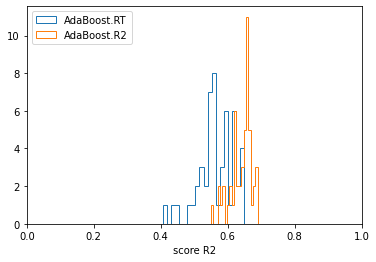

In [103]:
score_rt = []
score_r2 = []

for i in tqdm(range(50)):
    reg = AdaBoost(n_estimators=30, method="RT")
    reg.fit(X_train, y_train)

    predicted = reg.predict(X_test, reg.n_estimators)
    score_rt.append(reg.score(predicted, y_test))
        
    reg = AdaBoost(n_estimators=30, method="R2")
    reg.fit(X_train, y_train)

    predicted = reg.predict(X_test, reg.n_estimators)
    score_r2.append(reg.score(predicted, y_test))
      
plt.hist(score_rt, bins=20, label='AdaBoost.RT', histtype="step")
plt.hist(score_r2, bins=20, label='AdaBoost.R2', histtype="step")
plt.xlabel("score R2")
plt.legend()
plt.xlim(0, 1)

plt.show()

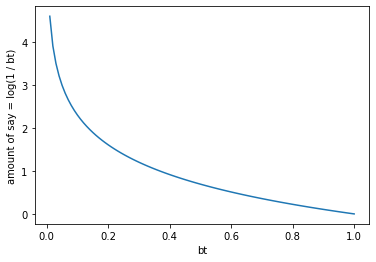

In [155]:
bt = np.linspace(0.01, 1, 100)
plt.plot(bt, np.log(1 / bt))
plt.ylabel("amount of say = log(1 / bt)")
plt.xlabel("bt")
plt.show()